# Neural Networks

## 1. Neural Networks
In this section, we will implement backpropagation algorithm to learn the parameters for the neural network.

### 1.1 Visualizing the data
The data is the same as assignment 3, 5000 training examples, each contains a 20 pixel by 20 pixel grayscale image of the digit. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
from scipy.io import loadmat

data = loadmat('ex3data1.mat')

X = data["X"]   # 5000x400 np array
y = data["y"]   # 5000x1 np array (2d)
y = y.flatten() # change to (5000,) 1d array and 
y[y==10] = 0    # in original data, 10 is used to represent 0

In [3]:
def displayData(X):
    """ displays the 100 rows of digit image data stored in X in a nice grid. 
        It returns the figure handle fig, ax
    """
    
    # form the big 10 x 10 matrix containing all 100 images data
    # padding between 2 images
    pad = 1
    # initialize matrix with -1 (black)
    wholeimage = -np.ones((20*10+9, 20*10+9))
    # fill values
    for i in range(10):
        for j in range(10):
            wholeimage[j*21:j*21+20, i*21:i*21+20] = X[10*i+j, :].reshape((20, 20))
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(wholeimage.T, cmap=plt.cm.gray, vmin=-1, vmax=1)
    ax.axis('off')
    
    return fig, ax

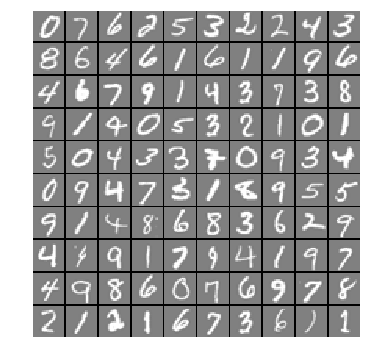

In [4]:
# randomly select 100 data points to display
rand_indices = np.random.randint(0, 5000, size=100)
sel = X[rand_indices, :]

# display images
fig, ax = displayData(sel)

### 1.2 Model representation
Our neural network is shown in the following figure. It has 3 layers: an input layer, a hidden layer and an output layer. The neural network used contains 25 units in the 2nd layer and 10 output units (corresponding to 10 digit classes).

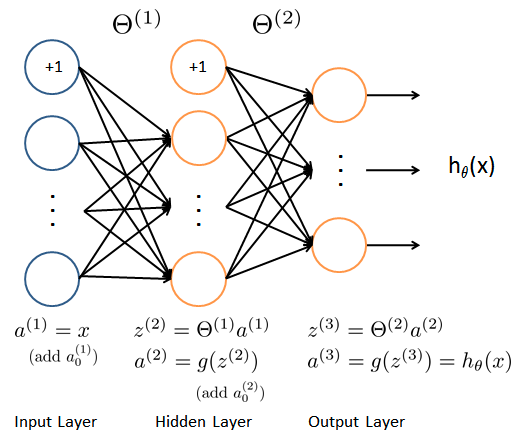



### 1.3 Feedforward and cost function
Recall that the cost function for the neural network (without regularization) is:
$$ J(\theta)=\frac{1}{m}\sum_{i=1}^{m} \sum_{k=1}^{K}[-y^{(i)}log((h_\theta(x^{(i)}))_k)-(1-y^{(i)})log(1-(h_\theta(x^{(i)}))_k)]$$

where $h_\theta(x^{(i)})$ is computed as shown in the above figure and K=10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation of the k-th output unit. Also, remember that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, so:


$$ y = \left[\matrix{1\\ 0\\ 0\\ \vdots\\ 0}\right], \left[\matrix{0\\ 1\\ 0\\ \vdots\\ 0}\right], ..., or \left[\matrix{0\\ 0\\ 0\\ \vdots\\ 1}\right] $$

#### Vectorization
Matrix dimensions:

$X_{wb}$: 5000 x 401

$\Theta^{(1)}$: 25 x 401

$\Theta^{(2)}$: 10 x 26

$a^{(2)}$: 5000 x 25 or 5000 x 26 after adding intercept terms

$a^{(3)} or H_\theta(x)$: 5000 x 10

$Y$: 5000 x 10

$$a^{(2)} = g(X_{wb}\Theta^{(1)^T})$$

$$ H_\theta(x) = a^{(3)} = g(a^{(2)}_{wb}\Theta^{(2)^T})$$

$$ H_\theta(x) = \left[\matrix{-(h_\theta(x^{(1)}))^T-\\ -(h_\theta(x^{(2)}))^T-\\ \vdots\\ -(h_\theta(x^{(m)}))^T-}\right] $$

$$ Y = \left[\matrix{-(y^{(1)})^T-\\ -(y^{(2)})^T-\\ \vdots\\ -(y^{(m)})^T-}\right] $$

Therefore, cost is:

$$ J(\theta)=\frac{1}{m} \sum_{matrix-elements} (-Y .* log(H_\theta(x))-(1-Y) .* log(1-H_\theta(x))) $$

Note the element wise multiplication (.*) and sum of all matrix elements in the above equation.

### 1.4 Regularized cost function
The cost function for neural networks with regularization is given by:
$$ J(\theta)=\frac{1}{m}\sum_{i=1}^{m} \sum_{k=1}^{K}[-y^{(i)}log((h_\theta(x^{(i)}))_k)-(1-y^{(i)})log(1-(h_\theta(x^{(i)}))_k)] + \frac{\lambda}{2m}\left[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j, k}^{(1)})^2 + \sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j, k}^{(2)})^2\right]$$

Note that even though the additional regularization term seems complicated with all the cascaded Sigma symbols, it is actually just the sum of all elements (after taking square) in the $\Theta$ matrix, one of them is 25 by 400, the other is 10 by 25 (recall that bias term is by convention not included in regularization). If your regularization parameter $\lambda$ is very very large, then all your $\Theta$ will converge to zero.

#### Vectorization
For the regularization term, there's actually nothing much to vectorize. Using elementwise self-multiplication then sum all elements in the result will do it: 

$$ J(\theta)=\frac{1}{m} \sum_{matrix-elements} (-Y .* log(H_\theta(x))-(1-Y) .* log(1-H_\theta(x))) + \frac{\lambda}{2m} \left[\sum_{matrix-elements}(\Theta_{j, k}^{(1)} .* \Theta_{j, k}^{(1)})+\sum_{matrix-elements}(\Theta_{j, k}^{(2)} .* \Theta_{j, k}^{(2)})\right]$$

In [5]:
def sigmoid(z):
    """ sigmoid(z) computes the sigmoid of z. z can be a number,
        vector, or matrix. 
    """
    
    g = 1 / (1 + np.exp(-z))
    
    return g

In [6]:
def nnCostFunction(nn_params, input_lsize, hidden_lsize, num_labels, X, y, lmd):
    """ computes the cost and gradient of the neural network. The
        parameters for the neural network are "unrolled" into the vector
        nn_params and need to be converted back into the weight matrices. 

        The returned parameter grad should be a "unrolled" vector of the
        partial derivatives of the neural network.

        X should already include bias terms
        Y is a 2d matrix
    """
    
    # number of training samples
    m, n = X.shape
    
    # restore Theta1 and Theta2 from nn_params
    Theta1 = nn_params[:hidden_lsize*(input_lsize+1)].reshape((hidden_lsize, input_lsize+1))
    Theta2 = nn_params[hidden_lsize*(input_lsize+1):].reshape((num_labels, hidden_lsize+1))
    
    # forward propagation
    a2 = sigmoid(X @ Theta1.T)
    a2_wb = np.concatenate((np.ones((m, 1)), a2), axis=1)
    a3 = sigmoid(a2_wb @ Theta2.T) # i.e. H_theta
    
    
    # Calculate cost
    temp1 = -y * np.log(a3) - (1-y) * np.log(1-a3)
    temp2 = np.sum((Theta1**2).flatten()) + np.sum((Theta2**2).flatten())
    J = np.sum(temp1.flatten()) / m + lmd * temp2 / (2*m)
    
    return J
    

In [7]:
# define input_lsize, hidden_lsize and numb_labels
input_lsize = 400
hidden_lsize = 25
num_labels = 10
m = len(y) # number of samples

# add bias terms to X
X_wb = np.concatenate((np.ones((m, 1)), X), axis=1)

# convert y to 2d matrix Y, 5000 by 10
# each row represents a sample, containing 0 or 1
Y = np.zeros((m, num_labels))
for i, v in enumerate(y):
#     # NOTE: v=0 maps to position 9 
#     if v != 0:
#         Y[i, v-1] = 1
#     else:
#         Y[i, 9] = 1
#print(Y[:100, :])
    # using Python's zero-indexing convention
    Y[i, v] = 1

# Load pre-calculated nn_params Theta1 and Theta2
# In ex4weights are 2 parameters:
# Theta1: 25 by 401
# Theta2: 10 by 26

# from scipy.io import loadmat
data = loadmat('ex3weights.mat')

Theta1 = data["Theta1"]   
Theta2 = data["Theta2"]

# unroll Theta1 and Theta2 into nn_params
# NOTE: ndarray.flatten() will unroll by row, which does not match the A(:) behavior in MATLAB (by column)
# However, since the flattened data will be reshaped by ndarray,reshape(), which by default
# reshape by row, so you will actually get the original Theta1 and Theta2 back
# In summary, your flatten() and reshape() function should use the same order
# either both by numpy default, or both by 'F' order
nn_params = np.concatenate((Theta1.flatten(), Theta2.flatten()))
print(nn_params.shape)   # should be (10285,)

# Regularization factor
lmd = 0

# Test nnCostFunction()
J = nnCostFunction(nn_params, input_lsize, hidden_lsize, num_labels, X_wb, Y, lmd)

print(J)
print("Expected ~0.287629")

(10285,)
10.4414596728
Expected ~0.287629


In [8]:
# test cost function with reularization
lmd = 1
J = nnCostFunction(nn_params, input_lsize, hidden_lsize, num_labels, X_wb, Y, lmd)

print(J)
print("Expected around 0.383770")

10.5383183039
Expected around 0.383770


## 2. Backpropagation
In this part, we implement the backpropagation algo to compute the gradient for the neural network cost function. Once this is done, we will be able to train the neural network by minimizing the cost function using an optimizer.

### 2.1 Sigmoid gradient
The gradient for the sigmoid function can be computed as:
$$ g'(z)=\frac{d}{dz}g(z)=g(z)(1-g(z))$$

where
$$g(z)=\frac{1}{1+e^{-z}}$$

For large values (both positive and negative) of z, the gradient should be close to 0. When z = 0, the gradient should be exactly 0.25.

In [9]:
def sigmoidGradient(z):
    """ computes the gradient of the sigmoid function
        evaluated at z. This should work regardless if z is a matrix or a
        vector. In particular, if z is a vector or matrix, you should return
        the gradient for each element.
    """
    
    return sigmoid(z) * (1 - sigmoid(z))

In [10]:
# test sigmoidGradient(z)
z = np.array([-10, 0, 10])
print(sigmoidGradient(z))

[  4.53958077e-05   2.50000000e-01   4.53958077e-05]


### 2.2 Random initialization
When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. Otherwise, the units in hidden layers will be identical to each other. 
One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init}=0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

In [11]:
def randInitializeWeights(L_in, L_out):
    """ randomly initializes the weights of a layer with 
        L_in incoming connections and L_out outgoing connections. 

        Note that return variable W should be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms. 
    """
    
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1+L_in) * 2 * epsilon_init - epsilon_init
    
    return W    

### 2.3 Backpropagation
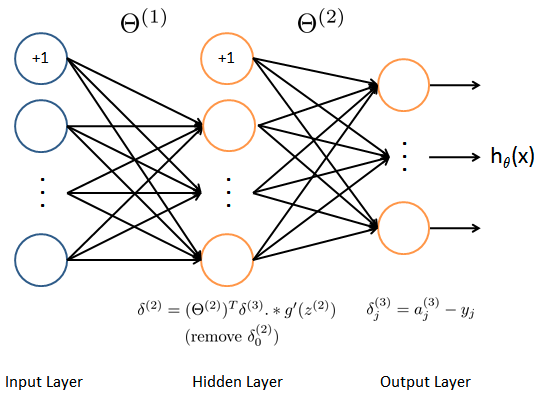

Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example (x(t); y(t)), we will first run a "forward pass" to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an "error term" $\delta_j^{(l)}$ that measures how much that node was "responsible" for any errors in the output. 

For an output node, we can directly measure the difference between the network's activation and the true target value, and use that to define $\delta_j^{(3)}$(since layer 3 is the output layer). For the hidden units, you will compute
$\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l + 1)$.

Detailed steps are as follows:

1) Perform a feedforward pass, computing the activations for Layers 2 and 3

2) For each output unit k in Layer 3 (the output layer), set
$$\delta_k^{(3)}=a_k^{(3)}-y_k$$
where $y_k\in[0,1]$ indicates whether the current training example belongs to class k or not. 


3) For Layer 2, set
$$\delta^{(2)} = (\Theta^{(2)})^T\delta^{(3)}.*g'(z^{(2)})$$


4) Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$:
$$\Delta^{(l)}=\Delta^{(l)}+\delta^{(l+1)}(a^{(l)})^T$$

Do this for all training examples.

5) Obtain the gradient by dividing the accumulated gradients by m:
$$\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)}$$


#### Vectorization
Here, we still use the full vectorization form that we used above, so we have:

$$\delta^{(3)}=a^{(3)}-y$$

$$\delta^{(2)} = \delta^{(3)}\Theta^{(2)}.*g'(z^{(2)})$$

$$\Delta^{(l)}=(\delta^{(l+1)})^Ta^{(l)}$$


where the matrix dimensions are as follows:

$X_{wb}, a^{(1)}$: 5000 x 401 with intercept terms 

$a^{(2)}, \delta^{(2)}, z^{(2)}$: 5000 x 25, without intercept terms

$a^{(3)}, y, \delta^{(3)}$: 5000 x 10

$\Theta^{(1)}$: 25 x 401 (but intercept terms will remain unchanged in gradient descent)

$\Theta^{(2)}$: 10 x 26 (but intercept terms will remain unchanged in gradient descent)

### 2.4 Regularized Neural Networks
To account for regularization, we can add an additional term after computing the gradient using backpropagation.

The formula are as follows:

$$\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)}\qquad for\; j=0$$
$$\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)}+\frac{\lambda}{m}\Theta_{ij}^{(l)}\qquad for\; j=1$$

Note that you should not regularize the first column of $\Theta$. 

In [12]:
def nnCostFunction2(nn_params, input_lsize, hidden_lsize, num_labels, X, y, lmd):
    """ computes the cost and gradient of the neural network. The
        parameters for the neural network are "unrolled" into the vector
        nn_params and need to be converted back into the weight matrices. 
 
        The returned parameter grad should be a "unrolled" vector of the
        partial derivatives of the neural network.

        X should already include bias terms
        Y is a 2d matrix
    """
    
    # number of training samples
    m, n = X.shape
    
    # restore Theta1 and Theta2 from nn_params
    Theta1 = nn_params[:hidden_lsize*(input_lsize+1)].reshape((hidden_lsize, input_lsize+1))
    Theta2 = nn_params[hidden_lsize*(input_lsize+1):].reshape((num_labels, hidden_lsize+1))
    
    # forward propagation
    z2 = X @ Theta1.T
    a2 = sigmoid(z2)
    a2_wb = np.concatenate((np.ones((m, 1)), a2), axis=1)
    a3 = sigmoid(a2_wb @ Theta2.T) # i.e. H_theta
    
    
    # Calculate cost
    temp1 = -y * np.log(a3) - (1-y) * np.log(1-a3)
    temp2 = np.sum((Theta1**2).flatten()) + np.sum((Theta2**2).flatten())
    J = np.sum(temp1.flatten()) / m + lmd * temp2 / (2*m)
    
    
    # Calculate gradient
    delta3 = a3 - y # 5000x10 
    delta2 = delta3 @ Theta2[:, 1:] * sigmoidGradient(z2) # 5000x25
    
    DT2 = delta3.T @ a2_wb # 10x26
    DT1 = delta2.T @ X # 25x401, X is a1
    
    Theta1_grad = DT1 / m
    Theta2_grad = DT2 / m
#     print("Theta1.shape is {}".format(Theta1.shape))
#     print("Theta2.shape is {}".format(Theta2.shape))
#     print("Theta1_grad.shape is {}".format(Theta1_grad.shape))
#     print("Theta2_grad.shape is {}".format(Theta2_grad.shape))
    
    # adding regularization
    Theta1_grad[:, 1:] += lmd * Theta1[:, 1:] / m
    Theta2_grad[:, 1:] += lmd * Theta2[:, 1:] / m
    
    # unroll gradients (note in numpy, default order is by row first)
    grad = np.concatenate((Theta1_grad.flatten(), Theta2_grad.flatten()))
    
    return J, grad

In [13]:
# test gradient without regularization
lmd = 0
debug_J, debug_grad = nnCostFunction2(nn_params, input_lsize, hidden_lsize, num_labels, X_wb, Y, lmd)
print(debug_grad[:10])
print("Expected: [  6.18712766e-05   0.00000000e+00   0.00000000e+00   4.15336892e-09 \n" +
   "-5.29868773e-08   1.42184272e-07   1.59715308e-06  -8.89999550e-07 \n" +
   "-1.45513067e-06  -4.08953470e-07]")

[  2.79735891e-02   0.00000000e+00   0.00000000e+00  -6.06594597e-08
   6.28438529e-07  -1.05493188e-06  -3.39491477e-07   1.83323091e-05
   1.84888681e-05   1.38600934e-05]
Expected: [  6.18712766e-05   0.00000000e+00   0.00000000e+00   4.15336892e-09 
-5.29868773e-08   1.42184272e-07   1.59715308e-06  -8.89999550e-07 
-1.45513067e-06  -4.08953470e-07]


In [14]:
# test gradient with regularization
lmd = 3
debug_J, debug_grad = nnCostFunction2(nn_params, input_lsize, hidden_lsize, num_labels, X_wb, Y, lmd)
print(debug_grad[:10])
print("Expected: [  6.18712766e-05  -6.33744979e-12   1.31648811e-12   2.87621717e-14 \n" +
   "3.09854983e-10  -3.45710507e-09  -2.85907272e-08  -1.54564033e-08 \n" +
   "2.10275154e-08   1.92242492e-08]")

[  2.79735891e-02  -6.33744979e-12   1.31648811e-12  -6.48127999e-08
   6.81735261e-07  -1.20057326e-06  -1.96523529e-06   1.92068522e-05
   1.99650263e-05   1.42882711e-05]
Expected: [  6.18712766e-05  -6.33744979e-12   1.31648811e-12   2.87621717e-14 
3.09854983e-10  -3.45710507e-09  -2.85907272e-08  -1.54564033e-08 
2.10275154e-08   1.92242492e-08]


### 2.6 Learning parameters using 'minimize' function

In [15]:
from scipy.optimize import minimize

# initial conidition, 1d array
init_Theta1 = randInitializeWeights(input_lsize, hidden_lsize)
init_Theta2 = randInitializeWeights(hidden_lsize, num_labels)
init_nn_params = np.concatenate((init_Theta1.flatten(), init_Theta2.flatten()))

# run optimization
result = minimize(nnCostFunction2, init_nn_params, args=(input_lsize, hidden_lsize, num_labels, X_wb, Y, lmd), 
                  method='TNC', jac=True, options={'disp': True})
print(result.x)

[  7.99766846e-01   1.24454484e-04   9.63662690e-05 ...,  -1.04304775e+00
  -1.69415207e+00  -1.20502716e+00]


In [16]:
# Obtain Theta1 and Theta2 from result.x
nn_params = result.x
Theta1 = nn_params[:hidden_lsize*(input_lsize+1)].reshape((hidden_lsize, input_lsize+1))
Theta2 = nn_params[hidden_lsize*(input_lsize+1):].reshape((num_labels, hidden_lsize+1))

In [17]:
def predict(X, Theta1, Theta2):
    """ predicts output given network parameters Theta1 and Theta2 in Theta. 
        The prediction from the neural network will be the label that has the largest output.
    """
    
    a2 = sigmoid(X @ Theta1.T)
    
    # add intercept terms to a2
    m, n = a2.shape
    a2_wb = np.concatenate((np.ones((m, 1)), a2), axis=1)
    
    a3 = sigmoid(a2_wb @ Theta2.T)
#     print(a3[:10, :])
    
    # apply np.argmax to the output matrix to find the predicted label 
    # for that training sample
    p = np.argmax(a3, axis=1)
#     p[p==10] = 0

    return p # this is a 1d array

In [18]:
# prediction accuracy
pred = predict(X_wb, Theta1, Theta2)
print(pred.shape)


accuracy = np.sum((pred==y).astype(int))/m*100
print('Training accuracy is {:.2f}%'.format(accuracy))

(5000,)
Training accuracy is 97.46%


Predicted 3 for this image: 


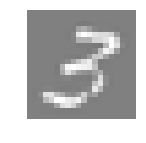

Predicted 4 for this image: 


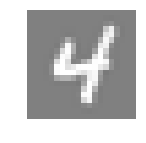

Predicted 3 for this image: 


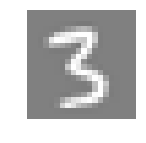

Predicted 3 for this image: 


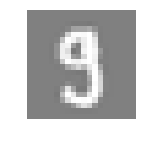

Predicted 1 for this image: 


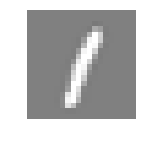

Predicted 5 for this image: 


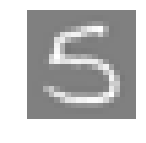

Predicted 0 for this image: 


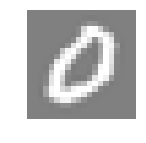

Predicted 9 for this image: 


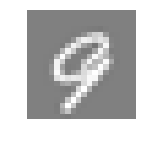

Predicted 9 for this image: 


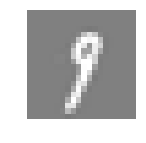

Predicted 7 for this image: 


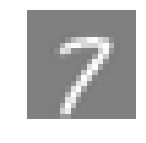

In [19]:
# randomly show 10 images and corresponding results
# randomly select 10 data points to display
rand_indices = np.random.randint(0, 5000, size=10)
sel = X[rand_indices, :]

for i in range(10):
    
    # Display predicted digit
    print("Predicted {} for this image: ".format(pred[rand_indices[i]]))
    
    # display image
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(sel[i, :].reshape(20, 20).T, cmap=plt.cm.gray, vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()